
# ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [14]:
# Parameters
SEQ_LEN = 24  # past 24 hours for each sample
TARGET_COL = 'OT'  # target variable: Oil Temperature
EPOCHS = 30 
BATCH_SIZE = 32

# VMD parameters
alpha = 2000       # moderate bandwidth constraint
tau = 0            # noise-tolerance (0 for no strict fidelity)
K = 30              # number of modes to extract
DC = 0              # no DC part imposed
init = 1            # initialize omegas uniformly
tol = 1e-7

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from vmdpy import VMD
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
save_dir = os.path.expanduser("~/Project/AttnLstm/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
print(df.columns)
# Ensure datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[[TARGET_COL]].values


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


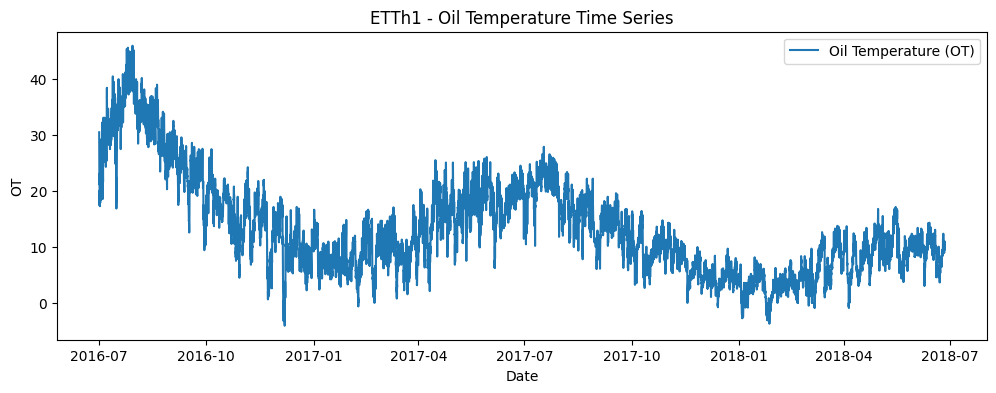

In [4]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['OT'], label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

## X,Y  and Train_test_split Simple

In [6]:
# Select relevant columns
df_model = df[['OT']].copy()

# Split index (80% train, 20% test)
split_idx = int(len(df_model) * 0.8)

# Split data chronologically
train_data = df_model[:split_idx]
test_data  = df_model[split_idx:]

# Fit scaler only on training data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled  = scaler.transform(test_data)

# Sequence creation function
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len, 0])  # target: OT
    return np.array(X), np.array(y)

# Create sequences
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test   = create_sequences(test_scaled, SEQ_LEN)

# If using pure LSTM on OT only
X_train_simple = X_train[:, :, 0:1]
X_test_simple  = X_test[:, :, 0:1]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (13912, 24, 1), y_train shape: (13912,)
X_test shape: (3460, 24, 1), y_test shape: (3460,)


## AttnLSTM+vmd+GA
    - VMD parameters (like alpha, K, tau, etc.)

    - Model parameters (like number of LSTM units, learning rate, dropout, etc.)

We’ll use a Genetic Algorithm (GA) for joint optimization of both sets.

### Why this architecture?

- The **stacked LSTM layers** capture hierarchical temporal‑dependencies within the input sequence.  
- The **Attention() layer** allows the model to dynamically focus on different time‑steps of the sequence (via self‑attention over the LSTM outputs).  
- By extracting both the **last output** and the **mean of the attention context**, the model combines both “summary” information and distributed attention information.  
- This **hybrid structure (LSTM + Attention)** is especially useful in non‑stationary, complex time series where long‑range dependencies and varying importance of past steps matter.

---

### 📚 Relevant Literature (JCR / peer‑reviewed journals)

Here are some notable papers that use attention mechanisms with LSTM (or RNN) for time‑series forecasting:

1. **Xu, Y., …** “Potential Analysis of the Attention‑Based LSTM Model in HVAC Energy Consumption Prediction”, *Frontiers in Energy Research* (2021).  
   - This paper applies an attention‑LSTM (“A‑LSTM”) to hourly HVAC load forecasting.  
   - [Frontiers link](https://www.frontiersin.org/journals/energy-research/articles/10.3389/fenrg.2021.730640/full)

2. **Wu, P., …** “A Combined Deep Learning Method with Attention‑Based LSTM (ATT‑LSTM) for Short‑Term Traffic Speed Prediction”, [journal] (2020).  
   - Uses attention + LSTM for traffic forecasting.  
   - [Wiley Online Library link](https://onlinelibrary.wiley.com/doi/10.1155/2020/8863724)

3. **Zhou, S., Guo, S., Du, B., Huang, S., Guo, J.** “A Hybrid Framework for Multivariate Time Series Forecasting of Daily Urban Water Demand Using Attention‑Based CNN‑LSTM”, *Sustainability, 14(17), 11086* (2022).  
   - Although this uses CNN+LSTM+Attention, it demonstrates the effective use of attention in LSTM‑based forecasting.  
   - [MDPI link](https://www.mdpi.com/2071-1050/14/17/11086)

4. **Kumar, I., …** “Attention‑based LSTM Network‑Assisted Time Series Forecasting of Production Data”, [journal] (2023).  
   - Direct “attention‑LSTM” application in a real industrial forecasting setting.  
   - [ScienceDirect link](https://www.sciencedirect.com/science/article/abs/pii/S0952197623006243)



### finding best params by GA

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random

# -----------------------------
# 1. Genetic Algorithm Configuration
# -----------------------------
POP_SIZE = 10       # number of candidate solutions
N_GEN = 5           # generations
MUTATION_RATE = 0.3 # probability of mutation

# Define search spaces
param_space = {
    # VMD parameters
    "alpha": (100, 5000),
    "K": (3, 10),
    "tau": (0.0, 0.5),
    # Model parameters
    "lstm_units": (32, 128),
    "learning_rate": (1e-4, 1e-2),
    "dropout": (0.0, 0.5)
}

def random_params():
    """Generate a random parameter set."""
    return {
        "alpha": np.random.uniform(*param_space["alpha"]),
        "K": np.random.randint(*param_space["K"]),
        "tau": np.random.uniform(*param_space["tau"]),
        "lstm_units": np.random.randint(*param_space["lstm_units"]),
        "learning_rate": 10**np.random.uniform(np.log10(param_space["learning_rate"][0]),
                                               np.log10(param_space["learning_rate"][1])),
        "dropout": np.random.uniform(*param_space["dropout"])
    }

# -----------------------------
# 2. Fitness Function
# -----------------------------
def evaluate(params):
    """Evaluate MSE of model trained with given parameters."""

    alpha, tau, K = params["alpha"], params["tau"], params["K"]

    # --- Apply VMD ---
    signal = data.flatten()
    u, u_hat, omega = VMD(signal, alpha, tau, K, DC=0, init=1, tol=1e-7)
    vmd_features = np.stack(u, axis=1)

    # Split and scale
    split_idx = int(len(vmd_features) * 0.8)
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(vmd_features[:split_idx])
    test_scaled  = scaler.transform(vmd_features[split_idx:])

    def create_sequences(data, seq_len):
        X, y = [], []
        for i in range(len(data) - seq_len):
            X.append(data[i:i + seq_len])
            y.append(data[i + seq_len, 0])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
    X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

    # --- Build model ---
    inputs = Input(shape=(SEQ_LEN, K))
    x = LSTM(params["lstm_units"], return_sequences=True)(inputs)
    x = Dropout(params["dropout"])(x)
    x = LSTM(params["lstm_units"], return_sequences=True)(x)
    lstm_out = LSTM(params["lstm_units"], return_sequences=True)(x)

    # Attention
    context = Attention()([lstm_out, lstm_out])
    last_output = Lambda(lambda x: x[:, -1, :])(lstm_out)
    context_mean = Lambda(lambda x: tf.reduce_mean(x, axis=1))(context)
    concat = Concatenate()([last_output, context_mean])
    dense_out = Dense(1)(concat)

    model = Model(inputs, dense_out)
    model.compile(optimizer=Adam(learning_rate=params["learning_rate"]), loss="mse")

    # Train briefly (for fitness estimation)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)

    return mse

# -----------------------------
# 3. GA Loop
# -----------------------------
population = [random_params() for _ in range(POP_SIZE)]

for gen in range(N_GEN):
    print(f"\n--- Generation {gen+1}/{N_GEN} ---")

    # Evaluate fitness
    fitness = []
    for individual in population:
        mse = evaluate(individual)
        fitness.append(mse)
        print(f"Params: {individual} → MSE: {mse:.6f}")

    # Select top 50%
    ranked = [x for _, x in sorted(zip(fitness, population), key=lambda pair: pair[0])]
    survivors = ranked[:POP_SIZE // 2]

    # Generate offspring
    offspring = []
    while len(offspring) < POP_SIZE // 2:
        p1, p2 = random.sample(survivors, 2)
        child = {}
        for key in param_space:
            child[key] = random.choice([p1[key], p2[key]])
            # Mutation
            if random.random() < MUTATION_RATE:
                if isinstance(param_space[key][0], int):
                    child[key] = np.random.randint(*param_space[key])
                else:
                    child[key] = np.random.uniform(*param_space[key])
        offspring.append(child)

    # Next generation
    population = survivors + offspring

# Final best parameters
best_params = min(population, key=lambda p: evaluate(p))
print("\n✅ Best Parameters Found:")
print(best_params)



--- Generation 1/5 ---
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Params: {'alpha': 1367.1397317965386, 'K': 8, 'tau': 0.11456011411733208, 'lstm_units': 37, 'learning_rate': 0.0020429532406784265, 'dropout': 0.3665836850835924} → MSE: 0.000019
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Params: {'alpha': 3261.8838494945503, 'K': 3, 'tau': 0.38327473157445335, 'lstm_units': 126, 'learning_rate': 0.0003184146937200934, 'dropout': 0.3300596184317551} → MSE: 0.000206
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Params: {'alpha': 4506.807556631154, 'K': 6, 'tau': 0.3124896087369391, 'lstm_units': 66, 'learning_rate': 0.0003433584065945064, 'dropout': 0.06878392635115332} → MSE: 0.000062
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Params: {'alpha': 1939.459859944288, 'K': 8, 'tau': 0.12563986602582689, 'lstm_units': 86, 'learning_rate': 0.007796481247185907, 'dropout': 0.26541640084595186} → MSE: 0.000066
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Params: {'alpha': 156.47509453190716, 'K': 6, 'tau': 0.1

### train best params for attlsm_vmd

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0808 - val_loss: 1.4995e-04
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 2.8994e-04 - val_loss: 2.1206e-05
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 1.2940e-04 - val_loss: 8.4268e-05
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 8.5733e-05 - val_loss: 1.3756e-05
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 8.0339e-05 - val_loss: 1.3561e-05
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.1711e-04 - val_loss: 5.4766e-05
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.0126e-04 - val_loss: 1.8657e-04
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 6.0639e-05 - val_loss: 2.5634e-04
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 1.0709e-04 - val_loss: 3.8720e-05
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 5.3553e-05 - val_loss: 9.8887e-05
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step

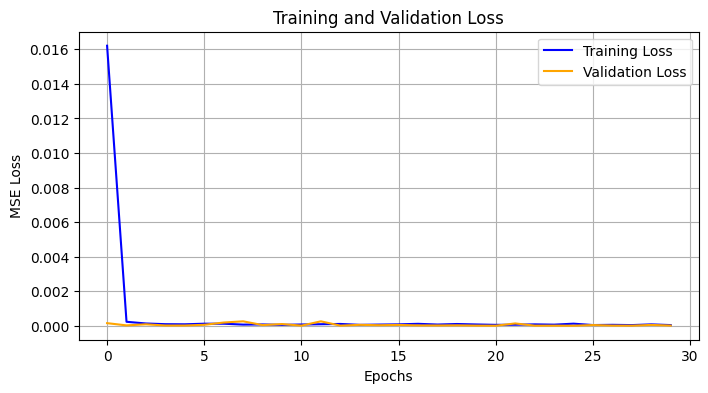

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


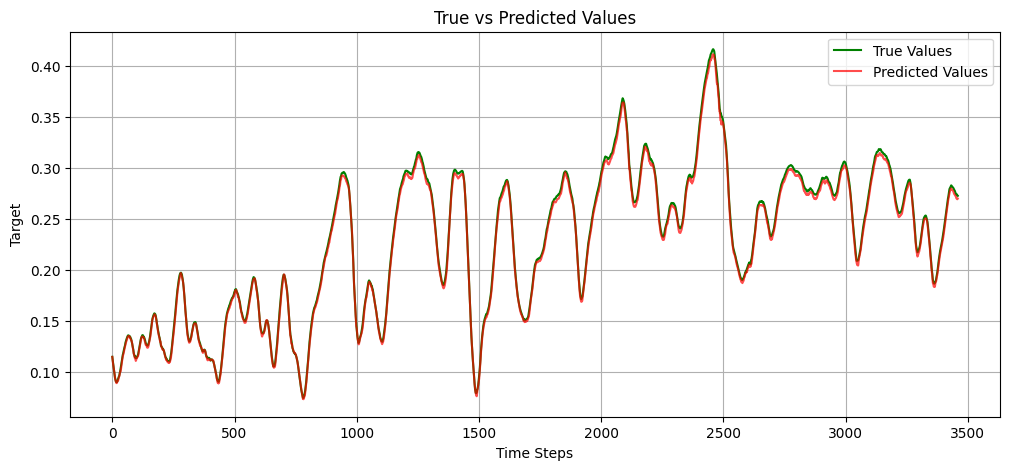

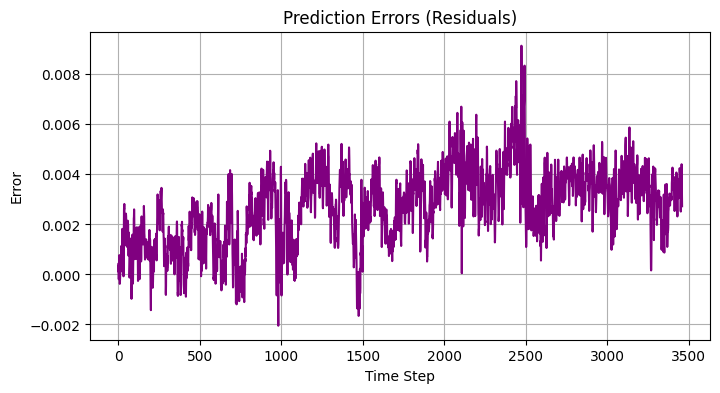

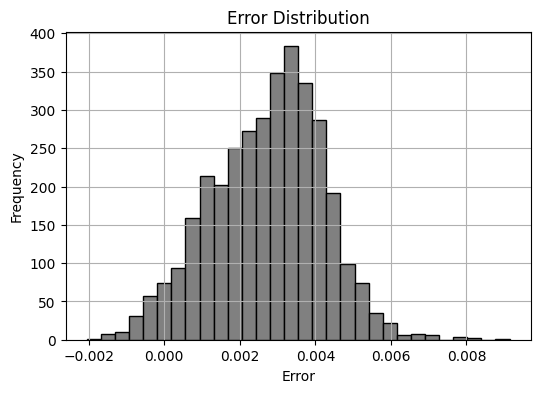


📊 Model Evaluation:
MSE  = 0.000010
MAE  = 0.002772
RMSE = 0.003105
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ Final Model MSE: 0.000010


In [18]:
# -----------------------------
# Final Training with Best Parameters
# -----------------------------
alpha, tau, K = best_params["alpha"], best_params["tau"], best_params["K"]
lstm_units = best_params["lstm_units"]
dropout = best_params["dropout"]
lr = best_params["learning_rate"]

# --- Apply VMD with optimal parameters ---
signal = data.flatten()
u, u_hat, omega = VMD(signal, alpha, tau, K, DC=0, init=1, tol=1e-7)
vmd_features = np.stack(u, axis=1)

# Train/test split
split_idx = int(len(vmd_features) * 0.8)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(vmd_features[:split_idx])
test_scaled  = scaler.transform(vmd_features[split_idx:])

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

# --- Build best model ---
inputs = Input(shape=(SEQ_LEN, K))
x = LSTM(lstm_units, return_sequences=True)(inputs)
x = Dropout(dropout)(x)
x = LSTM(lstm_units, return_sequences=True)(x)
x = Dropout(dropout)(x)
lstm_out = LSTM(lstm_units, return_sequences=True)(x)

context = Attention()([lstm_out, lstm_out])
last_output = Lambda(lambda x: x[:, -1, :])(lstm_out)
context_mean = Lambda(lambda x: tf.reduce_mean(x, axis=1))(context)
concat = Concatenate()([last_output, context_mean])
dense_out = Dense(1)(concat)

model = Model(inputs, dense_out)
model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

# --- Train final model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# -----------------------------
# 1️⃣ Training Loss Plot
# -----------------------------
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 2️⃣ Prediction vs True Values
# -----------------------------
y_pred = model.predict(X_test)

plt.figure(figsize=(12, 5))
plt.plot(y_test, label='True Values', color='green')
plt.plot(y_pred, label='Predicted Values', color='red', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Target')
plt.title('True vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 3️⃣ Prediction Error (Residuals)
# -----------------------------
errors = y_test - y_pred.flatten()

plt.figure(figsize=(8, 4))
plt.plot(errors, color='purple')
plt.title('Prediction Errors (Residuals)')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.grid(True)
plt.show()

# Optional: Histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=30, color='gray', edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Report Metrics
mse = np.mean(errors**2)
mae = np.mean(np.abs(errors))
rmse = np.sqrt(mse)

print(f"\n📊 Model Evaluation:")
print(f"MSE  = {mse:.6f}")
print(f"MAE  = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")



# --- Evaluate ---
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"\n✅ Final Model MSE: {mse:.6f}")


Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_65      │ (None, 24, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_201 (LSTM)     │ (None, 24, 122)   │     62,464 │ input_layer_65[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 24, 122)   │          0 │ lstm_201[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_202 (LSTM)     │ (None, 24, 122)   │    119,560 │ dropout_64[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 24, 122)   │          0 │ lstm_202[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_203 (LSTM)     │ (None, 24, 122)   │    119,560 │ dropout_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_64        │ (None, 24, 122)   │          0 │ lstm_203[0][0],   │
│ (Attention)         │                   │            │ lstm_203[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_128 (Lambda) │ (None, 122)       │          0 │ lstm_203[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_129 (Lambda) │ (None, 122)       │          0 │ attention_64[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_64      │ (None, 244)       │          0 │ lambda_128[0][0], │
│ (Concatenate)       │                   │            │ lambda_129[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 5)         │      1,225 │ concatenate_64[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 302,809 (1.16 MB)

 Trainable params: 302,809 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0318 - val_loss: 0.0014
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0023 - val_loss: 6.5966e-04
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0013 - val_loss: 5.7039e-04
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0010 - val_loss: 4.8185e-04
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 9.3119e-04 - val_loss: 4.7289e-04
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 8.0382e-04 - val_loss: 1.0987e-04
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 2.2711e-04 - val_loss: 6.9072e-05
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.8397e-04 - val_loss: 8.0030e-05
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.5598e-04 - val_loss: 1.1086e-04
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.3219e-04 - val_loss: 4.0963e-05
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.2758e

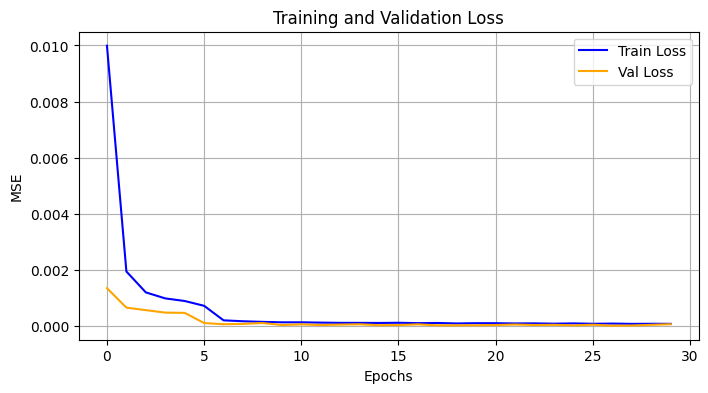

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


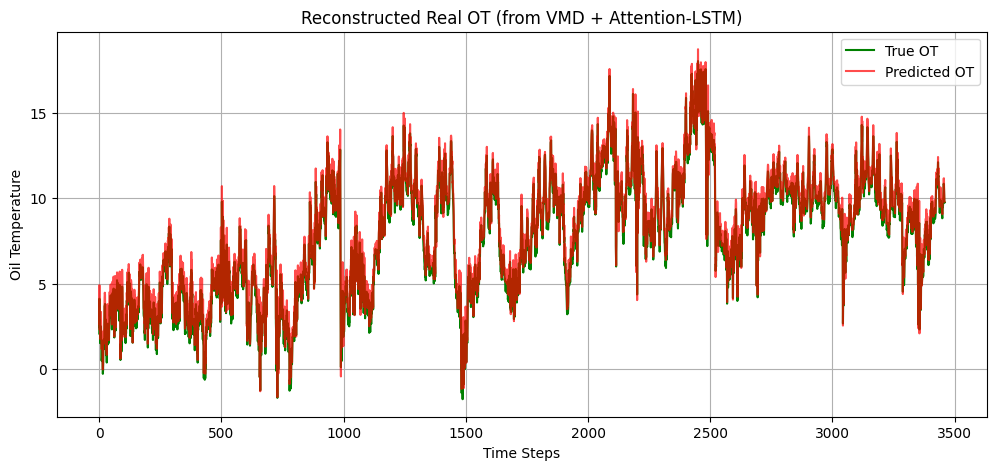

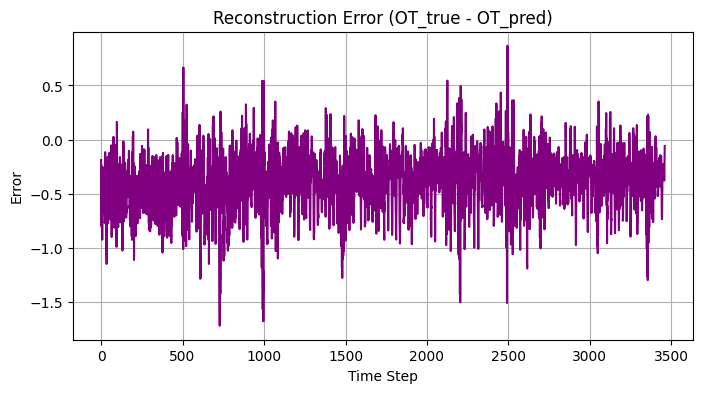

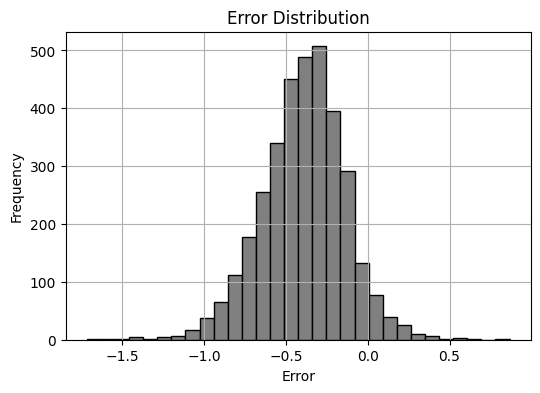


📊 Final Reconstructed OT Metrics:
MSE  = 0.222026
MAE  = 0.408112
RMSE = 0.471196


In [19]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# -----------------------------
# 1️⃣ Apply Optimal VMD Parameters
# -----------------------------
alpha, tau, K = best_params["alpha"], best_params["tau"], best_params["K"]
lstm_units = best_params["lstm_units"]
dropout = best_params["dropout"]
lr = best_params["learning_rate"]

signal = data.flatten()
u, u_hat, omega = VMD(signal, alpha, tau, K, DC=0, init=1, tol=1e-7)
vmd_features = np.stack(u, axis=1)  # shape: (time, K)

# -----------------------------
# 2️⃣ Train/Test Split
# -----------------------------
split_idx = int(len(vmd_features) * 0.8)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(vmd_features[:split_idx])
test_scaled  = scaler.transform(vmd_features[split_idx:])

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])  # all K IMFs at once
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

# -----------------------------
# 3️⃣ Build Best Model
# -----------------------------
inputs = Input(shape=(SEQ_LEN, K))
x = LSTM(lstm_units, return_sequences=True)(inputs)
x = Dropout(dropout)(x)
x = LSTM(lstm_units, return_sequences=True)(x)
x = Dropout(dropout)(x)
lstm_out = LSTM(lstm_units, return_sequences=True)(x)

context = Attention()([lstm_out, lstm_out])
last_output = Lambda(lambda x: x[:, -1, :])(lstm_out)
context_mean = Lambda(lambda x: tf.reduce_mean(x, axis=1))(context)
concat = Concatenate()([last_output, context_mean])
dense_out = Dense(K)(concat)  # predict all IMFs

model = Model(inputs, dense_out)
model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
model.summary()

# -----------------------------
# 4️⃣ Train the Model
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# -----------------------------
# 5️⃣ Loss Plot
# -----------------------------
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 6️⃣ Predict IMFs and Reconstruct OT
# -----------------------------
y_pred_imfs = model.predict(X_test)

# Inverse transform back to original IMF scale
y_pred_imfs_rescaled = scaler.inverse_transform(y_pred_imfs)
y_test_rescaled = scaler.inverse_transform(y_test)

# Reconstruct real OT by summing IMFs
y_pred_ot = np.sum(y_pred_imfs_rescaled, axis=1)
y_true_ot = np.sum(y_test_rescaled, axis=1)

# -----------------------------
# 7️⃣ Visualization
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(y_true_ot, label='True OT', color='green')
plt.plot(y_pred_ot, label='Predicted OT', color='red', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Reconstructed Real OT (from VMD + Attention-LSTM)')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 8️⃣ Error & Metrics
# -----------------------------
errors = y_true_ot - y_pred_ot
plt.figure(figsize=(8, 4))
plt.plot(errors, color='purple')
plt.title('Reconstruction Error (OT_true - OT_pred)')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=30, color='gray', edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# -----------------------------
# 9️⃣ Final Evaluation
# -----------------------------
mse = mean_squared_error(y_true_ot, y_pred_ot)
mae = mean_absolute_error(y_true_ot, y_pred_ot)
rmse = np.sqrt(mse)

print(f"\n📊 Final Reconstructed OT Metrics:")
print(f"MSE  = {mse:.6f}")
print(f"MAE  = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")


## LSTM+simple

/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 24, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_205 (LSTM)                 │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_206 (LSTM)                 │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,897 (847.25 KB)

 Trainable params: 216,897 (847.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0248 - val_loss: 0.0159
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0143 - val_loss: 0.0157
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0137 - val_loss: 0.0156
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0137 - val_loss: 0.0157
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0136 - val_loss: 0.0156
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0133 - val_loss: 0.0156
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0135 - val_loss: 0.0157
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0134 - val_loss: 0.0156
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0134 - val_loss: 0.0156
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0134 - val_loss: 0.0156
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0134 - val_loss: 0.0155
Epoch 12/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 

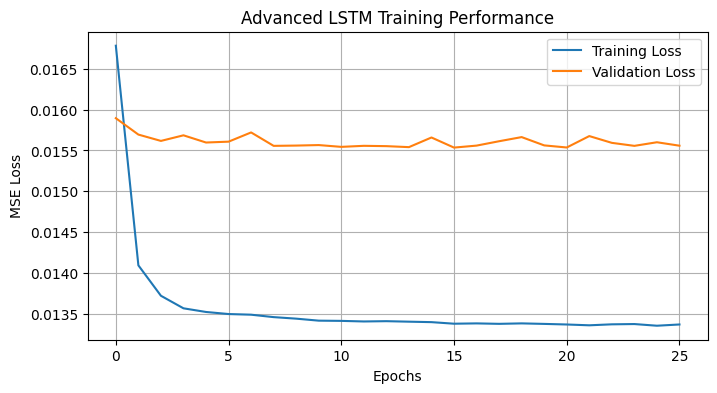

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


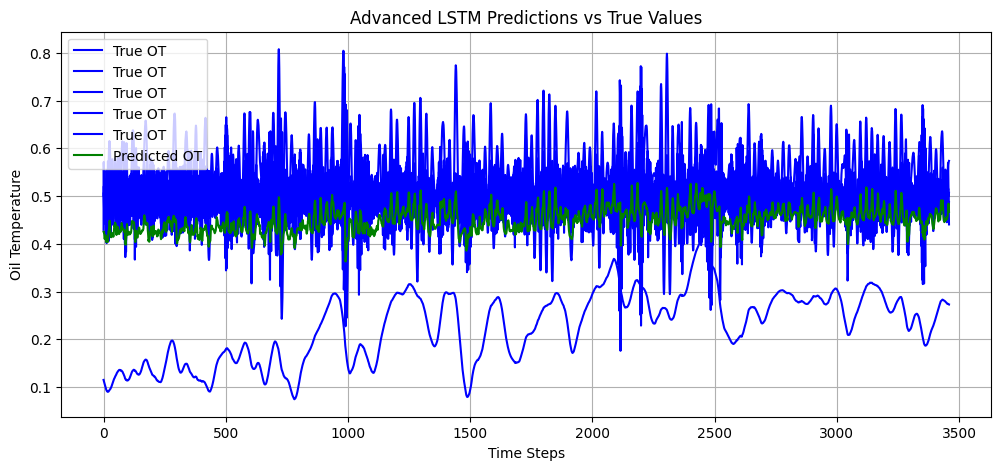

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Advanced LSTM model
advanced_lstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

advanced_lstm.compile(optimizer='adam', loss='mse')
advanced_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_adv = advanced_lstm.fit(
    X_train_simple, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history_adv.history['loss'], label='Training Loss')
plt.plot(history_adv.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Advanced LSTM Training Performance')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred_adv = advanced_lstm.predict(X_test_simple)

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='True OT', color='blue')
plt.plot(y_pred_adv, label='Predicted OT', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Advanced LSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()



📊 Model Performance Comparison:
VMD + Attention-LSTM:
  MSE  = 0.000010
  MAE  = 0.002772
  RMSE = 0.003105
  R²   = 0.998193
------------------------------------
Advanced BiLSTM:
  MSE  = 0.052875
  MAE  = 0.222551
  RMSE = 0.229945
  R²   = -8.912007


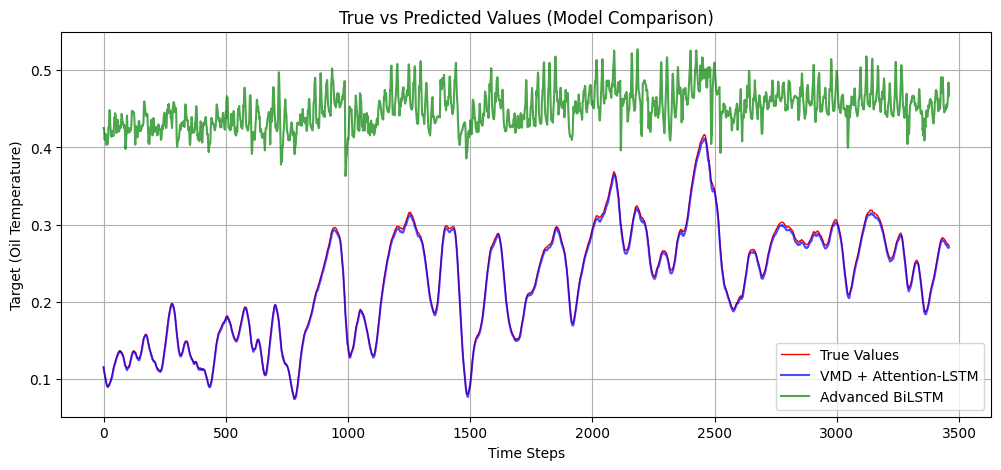

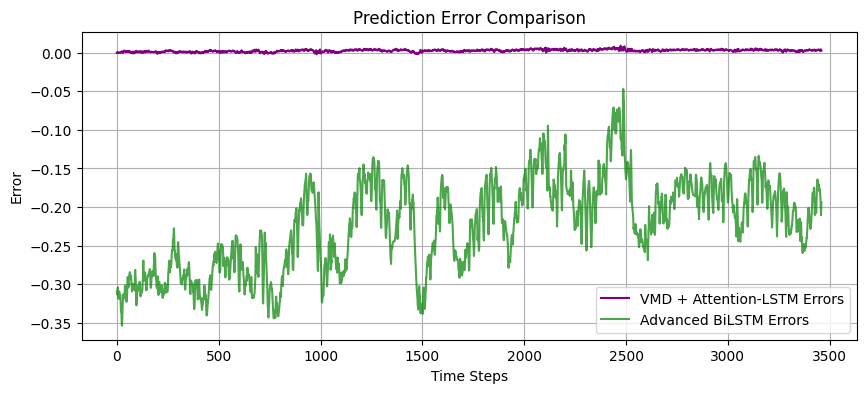

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------
# Ensure y_test is 1D (in case it has multiple columns)
# ----------------------------------------------------
if y_test.ndim > 1:
    y_test_single = y_test[:, 0]   # select the main target column
else:
    y_test_single = y_test

# Flatten predictions if needed
y_pred_vmd = y_pred.flatten()
y_pred_adv = y_pred_adv.flatten()

# ----------------------------------------------------
# Compute Metrics for Both Models
# ----------------------------------------------------
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

mse_vmd, mae_vmd, rmse_vmd, r2_vmd = compute_metrics(y_test_single, y_pred_vmd)
mse_adv, mae_adv, rmse_adv, r2_adv = compute_metrics(y_test_single, y_pred_adv)

# ----------------------------------------------------
# Print Comparison Results
# ----------------------------------------------------
print("\n📊 Model Performance Comparison:")
print("====================================")
print(f"VMD + Attention-LSTM:")
print(f"  MSE  = {mse_vmd:.6f}")
print(f"  MAE  = {mae_vmd:.6f}")
print(f"  RMSE = {rmse_vmd:.6f}")
print(f"  R²   = {r2_vmd:.6f}")
print("------------------------------------")
print(f"Advanced BiLSTM:")
print(f"  MSE  = {mse_adv:.6f}")
print(f"  MAE  = {mae_adv:.6f}")
print(f"  RMSE = {rmse_adv:.6f}")
print(f"  R²   = {r2_adv:.6f}")

# ----------------------------------------------------
# Plot: True vs Predicted Comparison
# ----------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(y_test_single, label='True Values', color='red', linewidth=1)
plt.plot(y_pred_vmd, label='VMD + Attention-LSTM', color='blue', alpha=0.7)
plt.plot(y_pred_adv, label='Advanced BiLSTM', color='green', alpha=0.7)
plt.title('True vs Predicted Values (Model Comparison)')
plt.xlabel('Time Steps')
plt.ylabel('Target (Oil Temperature)')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------
# Plot: Error (Residuals) Comparison
# ----------------------------------------------------
errors_vmd = y_test_single - y_pred_vmd
errors_adv = y_test_single - y_pred_adv

plt.figure(figsize=(10, 4))
plt.plot(errors_vmd, label='VMD + Attention-LSTM Errors', color='purple')
plt.plot(errors_adv, label='Advanced BiLSTM Errors', color='green', alpha=0.7)
plt.title('Prediction Error Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()
